In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
from numpy import loadtxt, corrcoef, delete, array, concatenate, vstack, ones, triu, where
from numpy.linalg import lstsq
from scipy.stats import f

In [2]:
BIG_CORRELATION = 0.9
SIGNIFICANCE = 0.05
MAX_POW = 2

In [3]:
dataset = loadtxt('lab1.csv', skiprows=1, delimiter=',')
# y = dataset[2:, 0]
# xs = dataset[2:, 1:].transpose()
y = dataset[:, 0]
xs = dataset[:, 1:].transpose()
regression_coefficients = []

In [4]:
worst_pairs = where(triu(abs(corrcoef(xs)), 1) > BIG_CORRELATION)
correlations = abs(corrcoef(y, xs))[0][1:]
worst = [i if correlations[i] < correlations[j] else j for i, j in zip(*worst_pairs)]
xs = delete(xs, worst, axis=0)

In [5]:
# accum = [array([y]), xs]
accum = [xs]
last = xs
for i in range(MAX_POW-1):
    last = [last[i]*xs[i:] for i in range(xs.shape[0])]
    accum += last
sequences = concatenate(accum); sequences.shape

(14, 40)

In [6]:
def get_residuum(y, regressors, coefficients):
    return y - array([c * r for c, r in zip(regressors, coefficients)]).sum(axis=0)

In [7]:
def get_coeffs(y, regressors, coefficients, sequences):
    residuum = get_residuum(y, regressors, coefficients)
    A = vstack([[residuum], sequences])
    best = abs(corrcoef(A)[0][1:]).argmax()
    regressor = sequences[best]
    sequences = delete(sequences, best, axis=0)
    regressors += [regressor]
    coefficients = lstsq(array(regressors).T, y)[0]
    new_residuum = get_residuum(y, regressors, coefficients)
    S = (residuum**2).sum(), (new_residuum**2).sum()
    F = (regressor.size - len(regressors)) * (S[0] - S[1]) / S[1]
    return regressors, coefficients, sequences, F

In [8]:
new_sequences = sequences.copy()
coefficients = [y.mean()]
regressors = [ones(sequences[0].size)]
all_coefficients = [coefficients[0]]
all_regressors = [regressors[0]]
for i in range(min(sequences.shape[0], y.size)):
    regressors, coefficients, new_sequences, F = get_coeffs(y, regressors, coefficients, new_sequences)
    all_coefficients.append(coefficients)
    all_regressors.append(regressors[-1])
    print(i, f.cdf(F, 1, regressors[0].size - i - 1))
    if f.cdf(F, 1, regressors[0].size - len(regressors) + 1) < SIGNIFICANCE:
        print('FINISH')
        break

0 0.999999999175
1 0.999854075404
2 0.998982535974
3 0.575571623993
4 0.550844105904
5 0.660713829744
6 0.999987997135
7 0.877618006627
8 0.595373424931
9 0.628668525997
10 0.254989198347
11 1.0
12 0.79527999615
13 0.213176253326


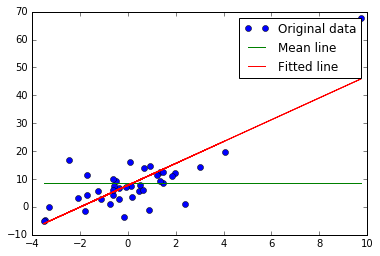

In [14]:
a, b = all_coefficients[1]
plt.plot(all_regressors[1], y, 'o', label='Original data')
plt.plot(all_regressors[1], all_coefficients[0] * all_regressors[0], label='Mean line')
plt.plot(all_regressors[1], a * all_regressors[0] + b * all_regressors[1], label='Fitted line')
plt.legend()
plt.show()